# Imputation

In [113]:
import sys
sys.path.append('D:/source/repos')
from utilities.std_imports import *
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

### Load data

In [114]:
df = pd.read_csv('D:/data/csv/missing.csv', parse_dates=['date'], index_col='date')
df_orig = pd.read_csv('D:/data/csv/missing_orig.csv', parse_dates=['date'], index_col='date')
print('Size ' , df.shape[0])
print('Nulls ',  df[df['value'].isnull()].shape[0])
df.head()

Size  204
Nulls  11


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


### Plot method

In [117]:
def plot_imputation(df_imp):
    plt.figure(figsize=[22,10])
    plt.plot(df_orig, color='red')
    plt.plot(df_imp, color='blue');

### Actual

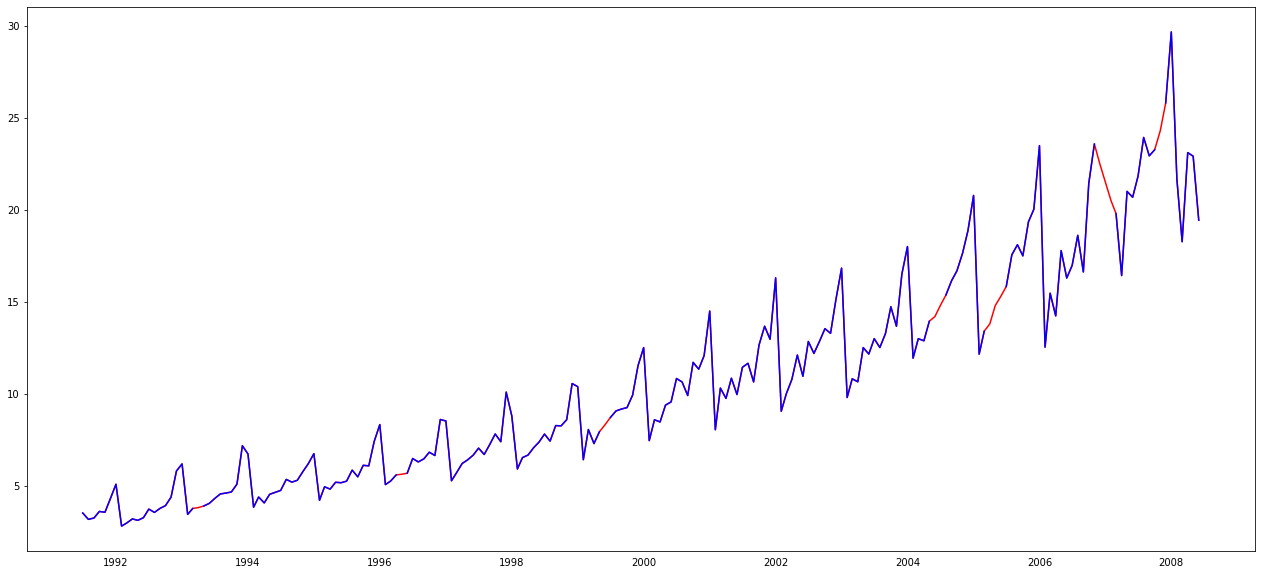

In [118]:
plot_imputation(df)

### Forward Fill 

MSE =  0.09


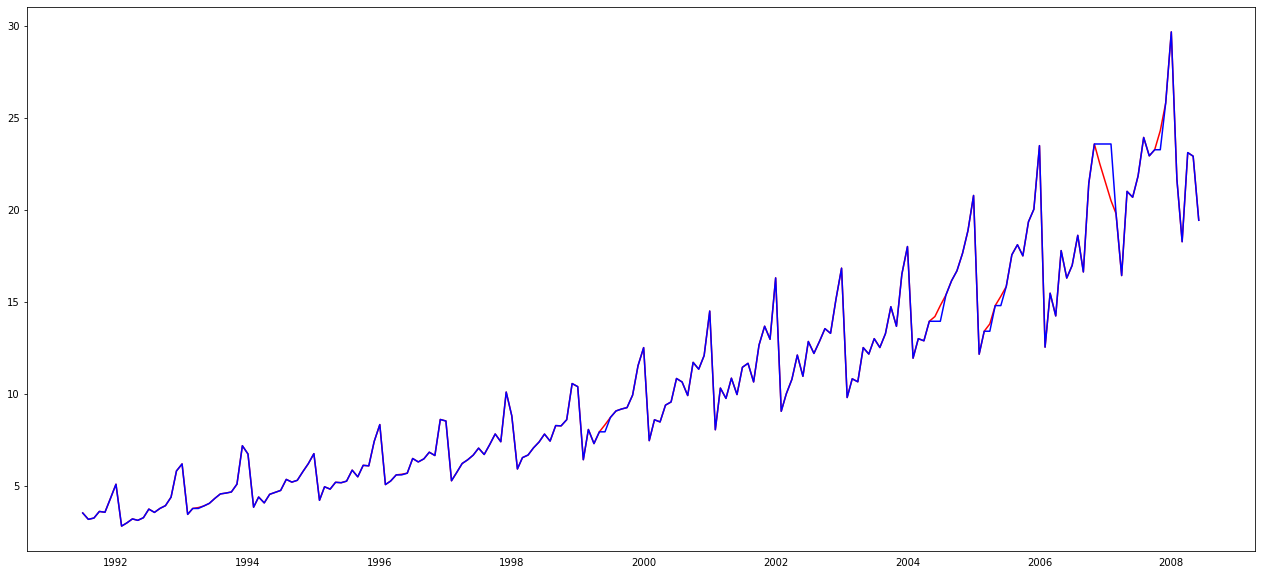

In [119]:
df_ffill = df.ffill() 
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
print('MSE = ', error)
plot_imputation(df_ffill)

### Backward fill

MSE =  0.08


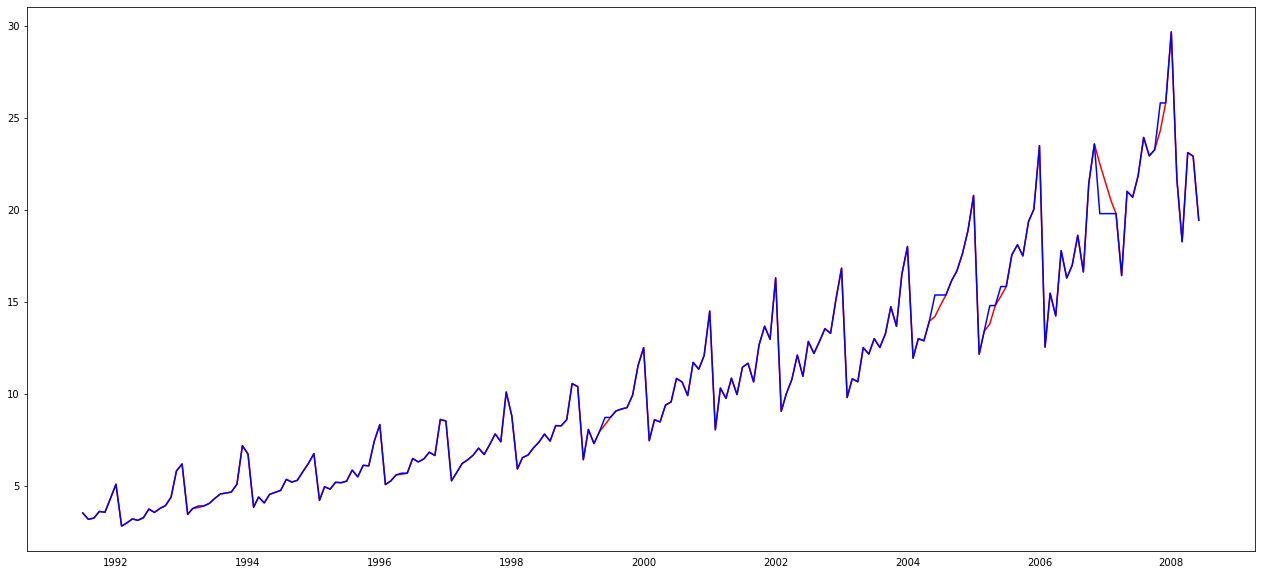

In [120]:
df_bfill = df.bfill() 
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
print('MSE = ', error)
plot_imputation(df_bfill)

### Linear Interpolation

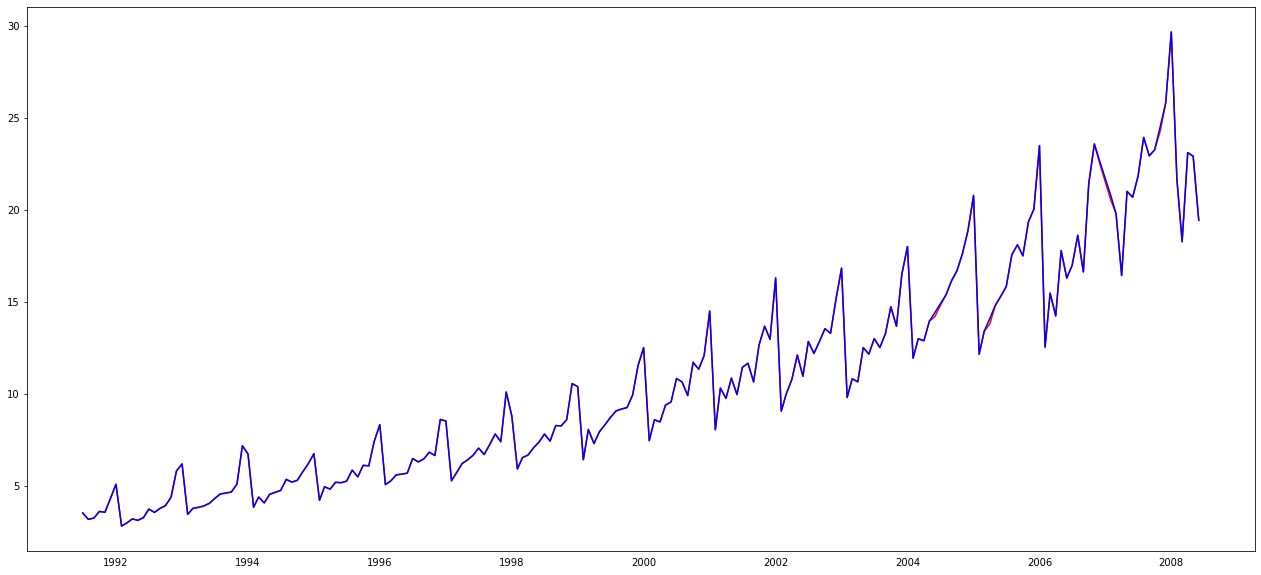

In [121]:
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
plot_imputation(df['linear_fill'])

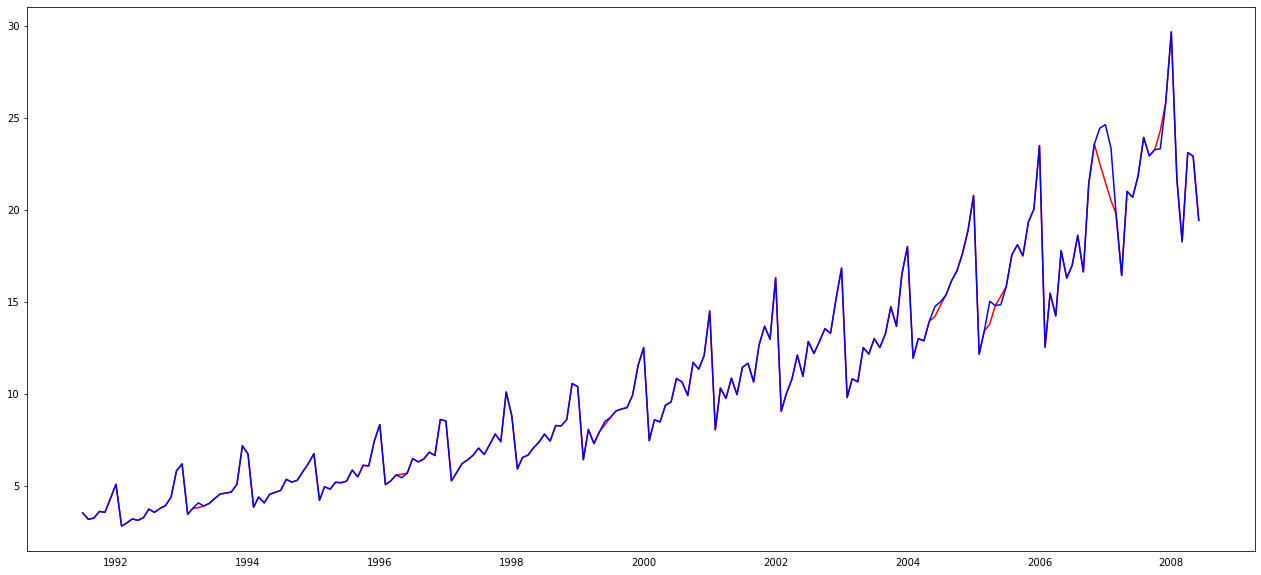

In [122]:
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
plot_imputation(df['cubic_fill'])

### KNN 

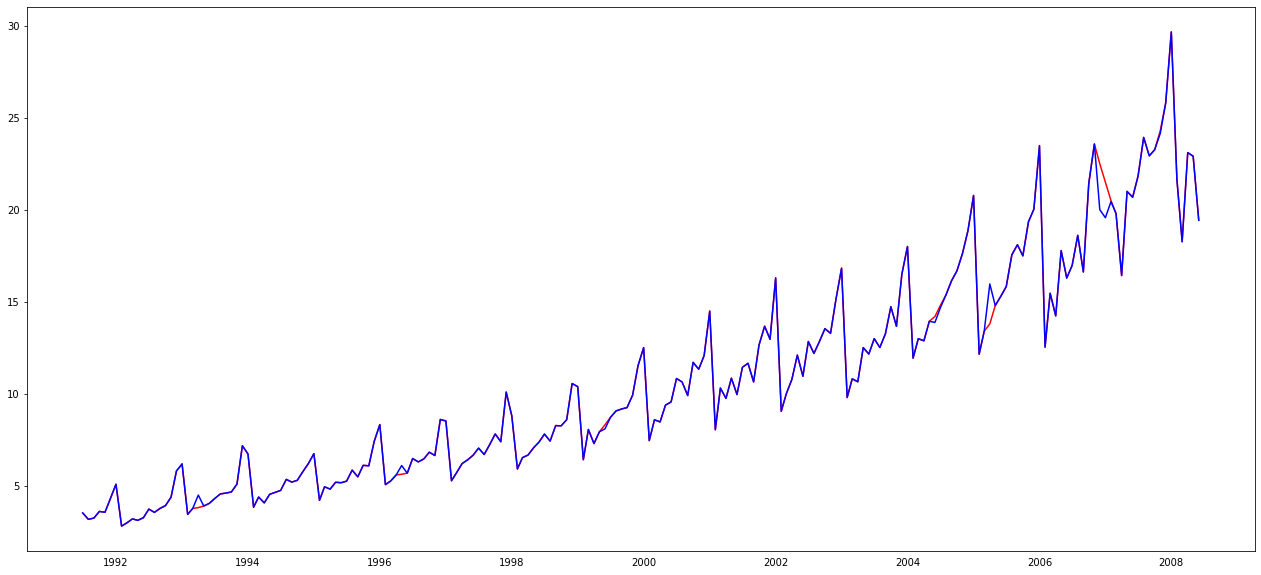

In [124]:
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
plot_imputation(df['knn_mean'])

###  Seasonal Mean 

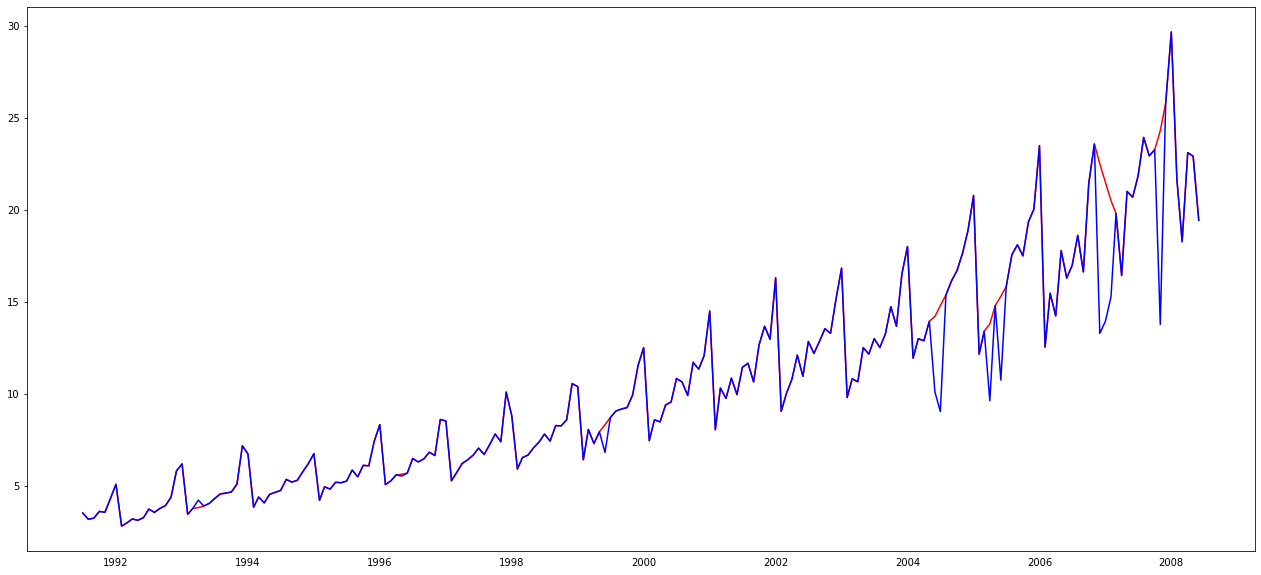

In [125]:
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
plot_imputation(df['seasonal_mean'])

### Credits & Links

https://www.machinelearningplus.com/time-series/time-series-analysis-python/  
https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html  
https://docs.scipy.org/doc/scipy/reference/interpolate.html